In [227]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.sparse import coo_matrix, hstack
import pickle

In [228]:
pd.options.display.max_columns = None

In [229]:
df_full = pd.read_csv('data/df_quotes_clean.csv', dtype={'label':str})
df_full.head()

label                                              quote  \
0     2                   pennsylvania banned alcohol sale   
1     2            666000 teacher laid already since march   
2     2  david perdue say hell everything power make su...   
3     2  say 47 additional county used software caused ...   
4     2        voter fraud exposed georgia 2600 vote found   

                context       author_id     author_name               date  \
0       a Facebook post     viral-image     Viral image  November 24, 2020   
1  a virtual roundtable       joe-biden       Joe Biden  November 18, 2020   
2                 an ad      jon-ossoff      Jon Ossoff  November 17, 2020   
3       a Facebook post      ted-nugent      Ted Nugent  November 17, 2020   
4       in a Live video  facebook-posts  Facebook posts  November 16, 2020   

                                 categories               staff  label_binary  \
0         Facebook Fact-checks, Coronavirus      Ciara O'Rourke             0   
1                    Education, Coronavirus       Bill McCarthy             0   
2             Georgia, Negative Campaigning       Tom Kertscher             0   
3           Elections, Facebook Fact-checks  Samantha Putterman             0   
4  Georgia, Elections, Facebook Fact-checks        Daniel Funke             0   

  context_clean affiliation  \
0      facebook        None   
1    roundtable    Democrat   
2            ad    Democrat   
3      facebook  Republican   
4         video        None   

                                         description  \
0  Graphics, pictures and charts shared on social...   
1  Joe Biden is President-elect of the United Sta...   
2  Jon Ossoff is a Democrat running to succeed fo...   
3  Ted Nugent, who lives near Waco, performed aft...   
4  Posters on Facebook and other social media net...   

                        link   gender date_formatted  date_year  date_month  \
0                        NaN  unknown     2020-11-24       2020          11   
1  https://www.joebiden.com/     male     2020-11-18       2020          11   
2      https://electjon.com/     male     2020-11-17       2020          11   
3  http://www.tednugent.com/     male     2020-11-17       2020          11   
4  https://www.facebook.com/  unknown     2020-11-16       2020          11   

   date_day  num_words  num_chars  avg_word_len  num_stopwords  \
0        24   0.026316   0.053738      0.611111       0.022727   
1        18   0.078947   0.093458      0.361111       0.068182   
2        17   0.157895   0.149533      0.208333       0.090909   
3        17   0.407895   0.443925      0.291667       0.295455   
4        16   0.078947   0.093458      0.361111       0.045455   

   author_13th-district-gop-slate  author_18-percent-american-public  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   
3                               0                                  0   
4                               0                                  0   

   author_60-plus-association  author_aaron-degroot  author_aarp  \
0                           0                     0            0   
1                           0                     0            0   
2                           0                     0            0   
3                           0                     0            0   
4                           0                     0            0   

   author_abc-news-us  author_abel-collins  author_abigail-spanberger  \
0                   0                    0                          0   
1                   0                    0                          0   
2                   0                    0                          0   
3                   0                    0                          0   
4                   0                    0                          0 

12694
5357
Random over-sampling:
1    12694
0    12694
Name: label_binary, dtype: int64


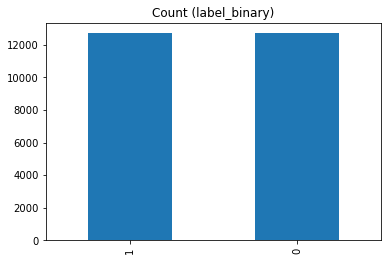

In [230]:
# Class count
count_class_0, count_class_1 = df_full['label_binary'].value_counts()

# Divide by class
df_class_0 = df_full[df_full['label_binary'] == 0]
print(len(df_class_0))
df_class_1 = df_full[df_full['label_binary'] == 1]
print(len(df_class_1))

df_class_1_resample = df_class_1.sample(count_class_0 - count_class_1, replace=True)
df_class_1_over = df_class_1.append(df_class_1_resample)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over['label_binary'].value_counts())

df_test_over['label_binary'].value_counts().plot(kind='bar', title='Count (label_binary)');
df_test_over.shape

df_full_proc = df_test_over

## Define the Features that will be Included in Modeling

In [231]:
text_features = ['num_words', 'num_chars', 'avg_word_len', 'num_stopwords']
date_features = [col for col in df_full_proc.columns if ('date_' in col) and (col not in ['date_formatted'])]
author_features = [col for col in df_full_proc.columns if ('author_' in col) and (col not in ['author_id', 'author_name'])]
context_features = [col for col in df_full_proc.columns if ('context_' in col) and (col != 'context_clean')]
gender_features = [col for col in df_full_proc.columns if 'gender_' in col]
affiliation_features = [col for col in df_full_proc.columns if 'affiliation_' in col]
features_cols = ['quote'] + text_features + date_features + author_features + context_features + gender_features + affiliation_features
features_cols = ['quote'] # To test with only quote

In [232]:
features = df_full_proc[features_cols]
#labels = df_full_proc['label'].to_numpy()
labels = df_full_proc['label_binary'].to_numpy()

In [233]:
features.shape

(25388, 1)

## Train Test Split

In [234]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, shuffle=True, random_state=42, stratify=labels)

## TF-IDF Vectorization

In [235]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.7)
tfidf_vect.fit(X_train['quote'].to_numpy())
X_train_quote =  tfidf_vect.transform(X_train['quote'].to_numpy())
X_test_quote =  tfidf_vect.transform(X_test['quote'].to_numpy())

X_train_quote.shape

(17771, 13813)

## Concatenate Quote and Features Sparse Matrices 

In [236]:
selected_features = [feat for feat in features if feat not in ['quote']]
X_train_full = hstack([coo_matrix(X_train_quote), coo_matrix(X_train[selected_features])])
X_test_full = hstack([coo_matrix(X_test_quote), coo_matrix(X_test[selected_features])])
X_train_full.shape

(17771, 13813)

In [237]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_full, y_train)
prediction = knn.predict(X_test_full)
accuracy = (prediction == y_test).mean()
print(f'Prediction accuracy {accuracy}')

Prediction accuracy 0.6574766968622817


In [238]:
clfNB = MultinomialNB()
clfNB.fit(X_train_full, y_train)
prediction = clfNB.predict(X_test_full)
accuracy = (prediction == y_test).mean()
print(f'Prediction accuracy {accuracy}')

Prediction accuracy 0.7043455428646449


In [239]:
clfDT = DecisionTreeClassifier()
clfDT.fit(X_train_full, y_train)
prediction = clfDT.predict(X_test_full)
accuracy = (prediction == y_test).mean()
print(f'Prediction accuracy {accuracy}')

Prediction accuracy 0.7643429171589865


In [240]:
clfRF = RandomForestClassifier()
clfRF.fit(X_train_full, y_train)
prediction = clfRF.predict(X_test_full)
accuracy = (prediction == y_test).mean()
print(f'Prediction accuracy {accuracy}')

Prediction accuracy 0.8198765918340554


In [144]:
def CrossValidate(clf, splits, X_train, y_train):
    scores = cross_val_score(clf, X_train, y_train, cv=splits)
    print('Cross-validated scores:', scores)
    print(f'Mean Accuracy: {scores.mean():0.2f} (+/- {scores.std() * 2:0.2f})')

In [145]:
clf = KNeighborsClassifier(n_neighbors=7, weights='uniform')
CrossValidate(clf, 5, X_train_full, y_train)

Cross-validated scores: [0.67017208 0.6749522  0.66897706 0.68634951 0.67344011]
Mean Accuracy: 0.67 (+/- 0.01)


In [146]:
clfNB = MultinomialNB()
CrossValidate(clfNB, 5, X_train_full, y_train)

Cross-validated scores: [0.7167782  0.71964627 0.72442639 0.7372699  0.72961989]
Mean Accuracy: 0.73 (+/- 0.01)


In [147]:
clfDT = DecisionTreeClassifier()
CrossValidate(clfDT, 5, X_train_full, y_train)

Cross-validated scores: [0.84392925 0.8542065  0.84942639 0.85393258 0.85273727]
Mean Accuracy: 0.85 (+/- 0.01)


In [187]:
clfRF = RandomForestClassifier()
CrossValidate(clfRF, 5, X_train_full, y_train)

Cross-validated scores: [0.92017208 0.92017208 0.92304015 0.92636863 0.92493426]
Mean Accuracy: 0.92 (+/- 0.00)


In [250]:

for i in range(100):
    row_raw = df_full_proc.loc[df_full_proc['label_binary'] == 1, ['quote', 'label', 'label_binary']].iloc[i]
    quote_raw = row_raw['quote']
    label_raw = row_raw['label_binary']
    print(quote_raw, row_raw['label'])
    quote = np.array([quote_raw])
    #print(quote)
    X_test_quote_single =  coo_matrix(tfidf_vect.transform(quote))
    #print(X_test_quote_single.shape)
    #NB = MultinomialNB()
    #NB.fit(X_train_full, y_train)
    model = clfRF
    predictions = model.predict(X_test_quote_single)
    #print(f'Predicted value: {predictions}')
    #print(f'Real value: {label_raw}')
    if predictions[0] != label_raw:
        print(i)



say there 75 reduction opioid dosage medical cannabis user 4
law governing transition presidential power doesnt require absolute winner say apparent winner 4
cant get test test iowa multiple site doctor clinic pharmacy stroke detection clinic center 4
unemployment report show america bouncing back 4
every single swingseat house democrat endorsed medicareforall reelection track win reelection every single one 4
west virginia near last u ranking education clean drinking water child mortality 4
say illinois made nationleading investment funding census outreach 4
mike parson opposes protection preexisting condition 4
protecting preexisting condition actually cosponsored legislation 4
say u rep ann wagner voted five time protecting preexisting condition 4
covid19 people dependent drug alcohol 4
antiblack life matter flag replaced american flag behind president trump waukesha campaign rally 4
11
upton voted dozen time kick thousand michigan family health insurance eliminate protection preexi

immigrant make majority essential worker place like new york city 4
congressional candidate chris jacob voted paid leave covid19 4


In [42]:
clf = SVC()
CrossValidate(clf, 5, X_train_full, y_train)

KeyboardInterrupt: 

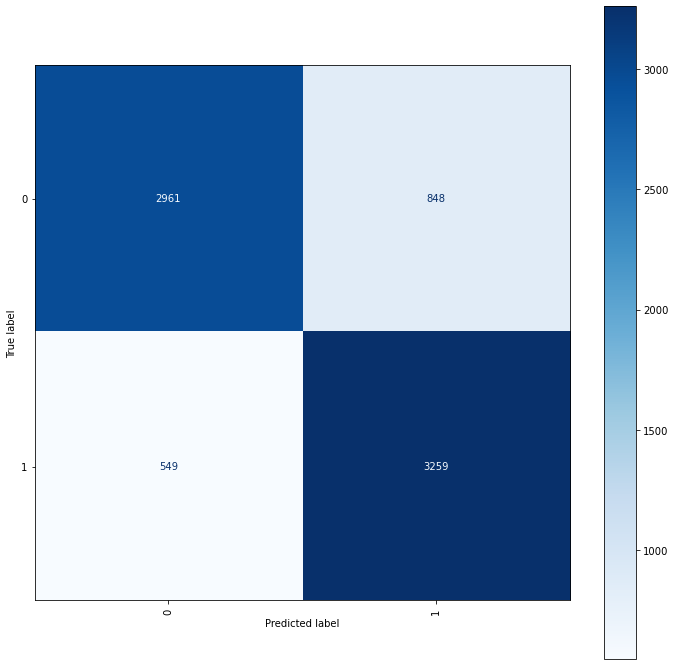

In [242]:
fig, ax = plt.subplots(figsize=(12, 12))
disp = metrics.plot_confusion_matrix(clfRF.fit(X_train_full, y_train), 
                             X_test_full, y_test,
                             display_labels=np.unique(y_train), 
                             ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')

In [267]:
print(len(y_test[y_test == 0]))
print(len(y_test[y_test == 1]))


4483
933


5416

In [243]:
pkl_filename = "app/models/RF_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clfRF, file)

In [244]:
pickle.dump(tfidf_vect, open("app/models/tfidf.pkl", "wb"))